In [1]:
import quandl, math, datetime
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
style.use('ggplot')

df = quandl.get('WIKI/AMD')

print(df.head())

             Open   High    Low  Close    Volume  Ex-Dividend  Split Ratio  \
Date                                                                         
1983-03-21  35.88  36.13  35.25  36.00  127700.0          0.0          1.0   
1983-03-22  34.88  35.88  34.00  34.00   82000.0          0.0          1.0   
1983-03-23  34.00  35.25  33.88  34.88  106800.0          0.0          1.0   
1983-03-24  34.88  35.13  34.63  35.13   98300.0          0.0          1.0   
1983-03-25  35.63  36.25  35.00  35.50   52600.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close  Adj. Volume  
Date                                                                 
1983-03-21   8.967543   9.030026  8.810086    8.997535     510800.0  
1983-03-22   8.717612   8.967543  8.497672    8.497672     328000.0  
1983-03-23   8.497672   8.810086  8.467680    8.717612     427200.0  
1983-03-24   8.717612   8.780094  8.655129    8.780094     393200.0  
1983-03-25   8.905060   9.060018 

In [3]:
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume', ]]
df["HL_PCT"] = (df['Adj. High'] - df['Adj. Close']) / df['Adj. Close'] * 100.0
df["PCT_change"] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume
Date                                                     
1983-03-21    8.997535  0.361111    0.334448     510800.0
1983-03-22    8.497672  5.529412   -2.522936     328000.0
1983-03-23    8.717612  1.060780    2.588235     427200.0
1983-03-24    8.780094  0.000000    0.716743     393200.0
1983-03-25    8.872569  2.112676   -0.364861     210400.0


In [4]:
forecast_col = 'Adj. Close'
df.fillna('-99999', inplace=True)

forecast_out = int(math.ceil(0.0011 * len(df)))

df['label'] = df[forecast_col].shift(-forecast_out)


print(df.head())

            Adj. Close    HL_PCT  PCT_change  Adj. Volume     label
Date                                                               
1983-03-21    8.997535  0.361111    0.334448     510800.0  8.155266
1983-03-22    8.497672  5.529412   -2.522936     328000.0  7.872843
1983-03-23    8.717612  1.060780    2.588235     427200.0  7.935326
1983-03-24    8.780094  0.000000    0.716743     393200.0  8.155266
1983-03-25    8.872569  2.112676   -0.364861     210400.0  8.405197


In [5]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
df.dropna(inplace=True)
y = np.array(df['label'])
y = np.array(df['label'])

print(len(X), len(y))

8819 8819


C:\Users\zayan\AppData\Local\Temp\ipykernel_19168\1019192577.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df.drop(['label'], 1))


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.2)

clf = LinearRegression()
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)

print(accuracy)
print(forecast_out)

0.9556171122646597
10


In [7]:
forecast_set = clf.predict(X_lately)

print(forecast_set, accuracy, forecast_out)

[11.24356822 11.3434996  11.39256081 11.36943976 11.03665865 11.18190617
 10.84586685 10.57352552 10.35885515  9.9728553 ] 0.9556171122646597 10


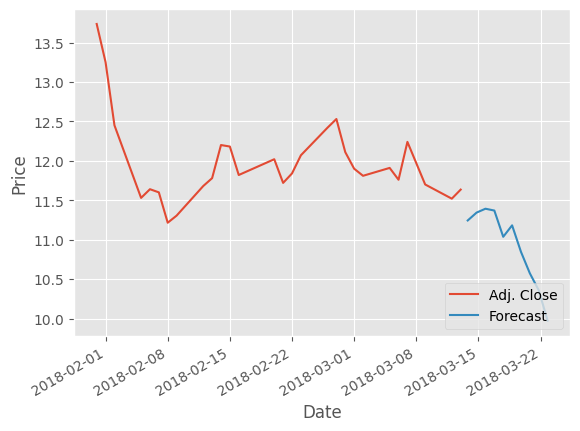

In [8]:
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range (len(df.columns) - 1)] + [i]
    
df['Adj. Close'].iloc[8790:].plot()
df['Forecast'].iloc[8790:].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()